# Урок 8. Деревья решений.

В уроках мы разбирали на небольшом наборе данных деревья решений без настройки гиперпараметров. Здесь предлагаем вам рассмотреть работу классификатора на более сложном датасете, применив настройку гиперпараметров.

### 1.
На датасете из предыдущего урока - load_wine() - обучите дерево решений (DecisionTreeClassifier).

*Примечание: при установке гиперпараметров модели и разбиении на тренировочный и тестовый датасеты используйте random_state=17 для воспроизводимости результатов.*

In [1]:
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [2]:
X, target = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=.2, random_state=17
)
model = DecisionTreeClassifier(random_state=17).fit(X_train, y_train)

### 2.
Отобразите дерево с помощью библиотеки graphviz.

*Примечание: если, изучая урок, вы не установили библиотеку graphviz, то необходимо сделать это сейчас.*

In [3]:
from sklearn import tree
import graphviz

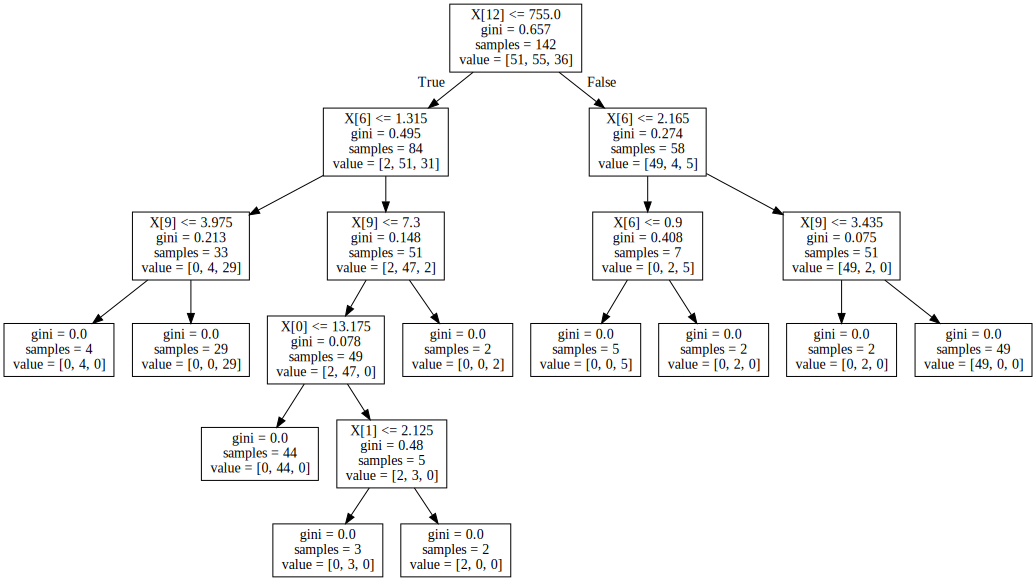

In [4]:
gv = tree.export_graphviz(model, out_file=None)
graphviz.Source(gv)

### 3.
Используя полученную модель, сделайте прогноз для тестовой выборки данных и, пользуясь встроенной функцией score(), определите точность модели.

In [5]:
model.score(X_test, y_test)

0.9722222222222222

Теперь попробуем сделать начальную настройку гиперпараметров и посмотреть, что из этого выйдет. 

### 4.

Постройте модель, указав гиперпараметр max_features равным 2 (так же указав random_state=17) и, сделав прогноз на тестовых данных, определите, стала ли модель работать точнее.

*Примечание: гиперпараметр max_features показывает модели, сколько различных признаков необходимо использовать каждый раз при принятии решения о разделении. То есть если, допустим, у вас имеются 50 признаков, а max_features=10, то в каждом узле случайным образом выбираются 10 признаков, которые будут использоваться для поиска лучшего разделения.*

In [6]:
model = DecisionTreeClassifier(max_features=2, random_state=17).fit(X_train, y_train)
model.score(X_test, y_test)

0.9444444444444444

### 5.
Теперь постройте граф дерева решений, используя graphviz.

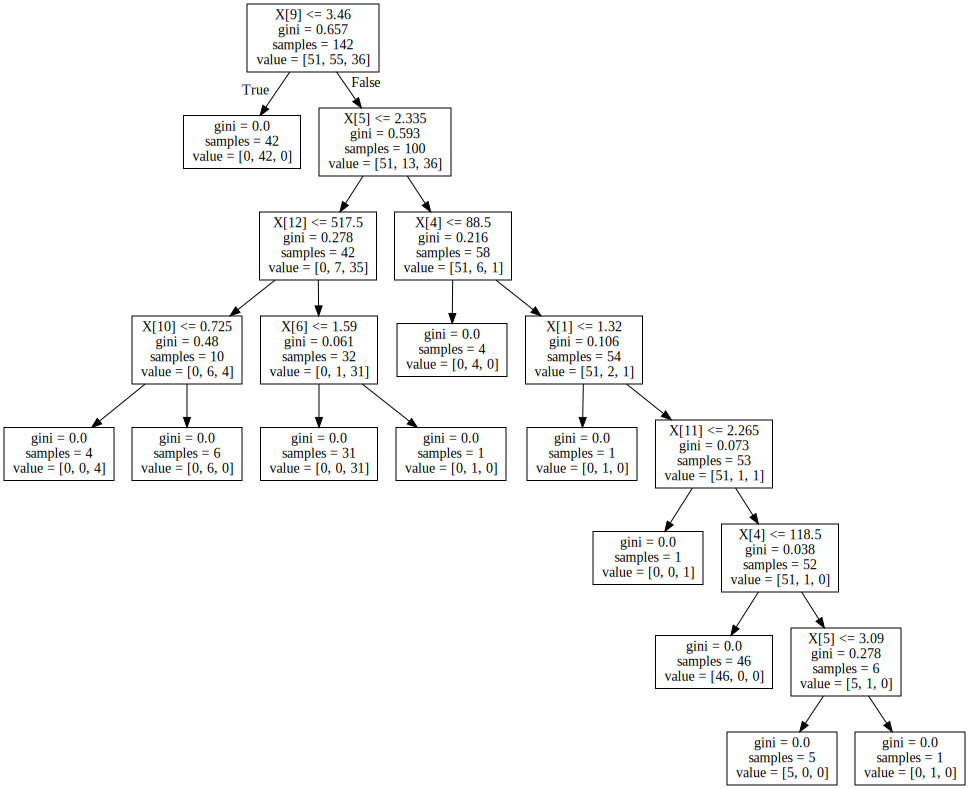

In [7]:
gv = tree.export_graphviz(model, out_file=None)
graphviz.Source(gv)

Модель работает точнее, чем без настройки гиперпараметров, но по графу можно увидеть, что глубина дерева увеличилась, при этом в нескольких листах присутствует только по одному объекту, из-за чего на тестовом наборе данных дерево могло несколько потерять обобщающую способность.

Так как главная задача модели - способность обобщаться на новые данные, то для подбора оптимальных гиперпараметров надо пожертвовать небольшой порцией данных, чтобы на ней во время обучения проверять качество модели.

Часто для этого используют кросс-валидацию: модель обучается K раз на (K-1) подвыборках исходной выборки, а на одной подвыборке проверяется (каждый раз на разной). Получаются K оценок качества модели, которые обычно усредняются, давая среднюю оценку.

Кросс-валидация применяется для подбора гиперпараметров модели в методе GridSearchCV(): для каждой уникальной совокупности значений параметров проводится кросс-валидация и выбирается лучшее сочетание параметров.

### 6.
Используя обученное в предыдущем задании дерево решений, настройте параметры max_depth и max_features на 5-кратной валидации с помощью GridSearchCV. Для этого в функцию GridSearchCV передайте параметры (tree, tree_params, cv=5).

*Примечание: tree здесь - не обученная модель, а объект, который инкапсулирует алгоритм. Например, в уроке мы его обозначали как dtc.*

In [8]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [9]:
tree_params = {'max_depth': range(1, 6), 
               'max_features': range(1, 10)}

tree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=17),
    tree_params,
    cv=5,
)

### 7.
С помощью метода tree_grid.fit() постройте модель на тренировочных данных и выведите лучшее сочетание параметров с помощью метода tree_grid.best_params_.

In [10]:
model = tree_grid.fit(X_train, y_train)
model.best_params_

{'max_depth': 5, 'max_features': 2}

### 8.
С помощью полученной модели сделайте прогноз - predict - для тестовой выборки и выведите долю верных ответов, проверив точность модели, используя функцию accuracy_score.

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
predicted = model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
accuracy

0.9444444444444444

### Бонус

In [43]:
from typing import Callable, NamedTuple, Iterator, Optional
import numpy as np


class Split(NamedTuple):
  feature_index: int
  value: float
  score: float

  @classmethod
  def make_empty(cls) -> "Split":
    return Split(-1, float('-inf'), float('inf'))

  def is_empty(self) -> bool:
    return self.feature_index == -1


class DTNode(NamedTuple):
  classes: np.ndarray
  split: Split
  left: Optional["DTNode"]
  right: Optional["DTNode"]

  @property
  def score(self) -> float:
    if self.split:
      return self.split.score
    return float("inf")

  def is_leaf(self) -> bool:
    return self.left == None and self.right == None


def print_tree(root: Optional[DTNode], depth=0):
  if not root: return
  # print(
  #     f"{' ' * depth}| X[{root.split.feature_index}] < {root.split.value:0.4f}"
  # )
  # print(f"{' ' * depth}| classes: {root.classes}")
  # print(f"{' ' * depth}| score: {root.score:0.4f}")
  print(' ' * depth + ", ".join([
    *([f"X[{root.split.feature_index}] < {root.split.value:0.4f}"]
    if not root.is_leaf() else []),
    f"classes: {root.classes}",
    f"score: {root.score:0.4f}"
  ]))
  print_tree(root.left, depth=depth + 2)
  print_tree(root.right, depth=depth + 2)


def calculate_criterion(classes_counts: np.ndarray) -> float:
  """Returns gini metrics"""
  total = classes_counts.sum()
  return 1 - np.square(classes_counts).sum() / total ** 2


def count_classes(
    labels: np.ndarray, x: np.ndarray
) -> np.ndarray:
  """The function assumes that labels are integers that go 
  from zero to len(labels)
  """
  c = np.zeros_like(labels)
  for i in x:
    c[i] += 1
  return c


def splits(
    X_train: np.ndarray, 
    y_train: np.ndarray,
    classes: np.ndarray
) -> Iterator[Split]:
  n_features = X_train.shape[1]
  # TODO: Change this to something more meaningful and pass it as a parameter.
  min_samples_split = 1  

  for feature_ind in range(n_features):
    values = np.linspace(
        min(X_train[:, feature_ind]), 
        max(X_train[:, feature_ind]), 
        100
    )
    for value in values[1:]:
      y_left = y_train[X_train[:, feature_ind] < value]
      y_right = y_train[X_train[:, feature_ind] >= value]

      if len(y_left) < min_samples_split or len(y_right) < min_samples_split:
        continue

      counts = count_classes(classes, y_left)
      score_left = calculate_criterion(counts)

      counts = count_classes(classes, y_right)
      score_right = calculate_criterion(counts)

      score = (
          len(y_left) * score_left + len(y_right) * score_right
      ) / len(y_train)
      yield Split(feature_ind, value, score)


def get_best_split(
    X_train: np.ndarray, 
    y_train: np.ndarray,
    classes: np.ndarray
) -> Split:  # Maybe returning None is better then some dummy object...
  return min(
      splits(X_train, y_train, classes), 
      default=Split.make_empty(),
      key=lambda x: x.score,
  )


def build_tree(
    X_train: np.ndarray, 
    y_train: np.ndarray,
    classes: np.ndarray
) -> DTNode:
  classes_counts = count_classes(classes, y_train)
  score = calculate_criterion(classes_counts)

  best_split = get_best_split(X_train, y_train, classes)

  if best_split.score >= score:
    # Can't split any more
    return DTNode(
        classes=classes_counts, 
        # This handles an edgecase where we can't split anything at root.
        # best_split.score would yield float('inf') in that case.
        split=best_split._replace(score=min(best_split.score, score)),
        left=None, 
        right=None
    )

  y_left = y_train[X_train[:, best_split.feature_index] < best_split.value]
  x_left = X_train[X_train[:, best_split.feature_index] < best_split.value]

  y_right = y_train[X_train[:, best_split.feature_index] >= best_split.value]
  x_right = X_train[X_train[:, best_split.feature_index] >= best_split.value]

  left = build_tree(x_left, y_left, classes)
  right = build_tree(x_right, y_right, classes)

  return DTNode(classes_counts, best_split, left, right)


def dt_predict_one(root: DTNode, x: np.ndarray) -> int:
  if root.is_leaf():
    return root.classes.argmax()

  if x[root.split.feature_index] < root.split.value:
    return dt_predict_one(root.left, x)

  return dt_predict_one(root.right, x)


def dt_predict(root: DTNode, X: np.ndarray) -> np.ndarray:
  return np.array([dt_predict_one(root, x) for x in X])


def fit_decision_tree(
    X_train: np.ndarray, 
    y_train: np.ndarray,
) -> Callable[[np.ndarray], np.ndarray]:

  root = build_tree(X_train, y_train, np.unique(y_train))
  return lambda x: dt_predict(root, x)


X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=17)
print_tree(build_tree(X_train, y_train, np.unique(y_train)))

model = fit_decision_tree(X_train, y_train)
print("accuracy: ", accuracy_score(y_test, model(X_test)))

X[12] < 756.2121, classes: [50 52 31], score: 0.3898
  X[9] < 4.8315, classes: [ 2 48 27], score: 0.1671
    X[0] < 13.0596, classes: [ 2 45  2], score: 0.1020
      classes: [ 0 41  0], score: 0.0000
      X[1] < 1.6691, classes: [2 4 2], score: 0.2500
        classes: [0 4 0], score: 0.0000
        X[0] < 13.2438, classes: [2 0 2], score: 0.0000
          classes: [2 0 0], score: 0.0000
          classes: [0 0 2], score: 0.0000
    X[6] < 1.3933, classes: [ 0  3 25], score: 0.0536
      classes: [ 0  0 24], score: 0.0000
      X[0] < 13.1277, classes: [0 3 1], score: 0.0000
        classes: [0 3 0], score: 0.0000
        classes: [0 0 1], score: 0.0000
  X[6] < 2.1630, classes: [48  4  4], score: 0.1162
    X[1] < 1.6255, classes: [0 2 4], score: 0.0000
      classes: [0 2 0], score: 0.0000
      classes: [0 0 4], score: 0.0000
    X[4] < 132.5051, classes: [48  2  0], score: 0.0000
      classes: [48  0  0], score: 0.0000
      classes: [0 2 0], score: 0.0000
accuracy:  0.9333333333

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=271)
print_tree(build_tree(X_train, y_train, np.unique(y_train)))

model = fit_decision_tree(X_train, y_train)
print("accuracy: ", accuracy_score(y_test, model(X_test)))

X[12] < 759.4949, classes: [52 46 35], score: 0.3640
  X[11] < 2.1744, classes: [ 1 45 30], score: 0.1224
    X[3] < 17.0717, classes: [ 0  3 29], score: 0.0000
      classes: [0 3 0], score: 0.0000
      classes: [ 0  0 29], score: 0.0000
    X[6] < 0.5463, classes: [ 1 42  1], score: 0.0444
      classes: [0 0 1], score: 0.0000
      X[12] < 721.3939, classes: [ 1 42  0], score: 0.0233
        classes: [ 0 41  0], score: 0.0000
        X[0] < 12.3392, classes: [1 1 0], score: 0.0000
          classes: [0 1 0], score: 0.0000
          classes: [1 0 0], score: 0.0000
  X[5] < 1.9143, classes: [51  1  5], score: 0.0292
    X[1] < 1.6370, classes: [0 1 5], score: 0.0000
      classes: [0 1 0], score: 0.0000
      classes: [0 0 5], score: 0.0000
    classes: [51  0  0], score: 0.0000
accuracy:  0.8666666666666667
